<a href="https://colab.research.google.com/github/iness000/Recipe-Generation-Based-on-Given-Ingredients/blob/main/eMlProjectDeliverable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Recipe Generation Based on Given Ingredients**

Experiment overview



   This project aims to develop a model that can generate cooking recipes based on a list of provided ingredients. We'll use a Transformer-based architecture, a powerful deep learning model well-suited for sequence-to-sequence tasks.

   In essence,we used a powerful combination of deep learning libraries (PyTorch, Transformers) and data processing tools (Pandas, SentencePiece, Rouge-Score) to build and evaluate a recipe generation model.

# **Transformer Architecture**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install tensorflow


In [ ]:
# Import necessary libraries
import pandas as pd
import torch
from transformers import AutoTokenizer
from torchvision import transforms, models
from PIL import Image
import os
import numpy as np

# Load the dataset
file_path = "/content/drive/MyDrive/Colab Notebooks/Food Ingredients and Recipe Dataset with Image Name Mapping.csv"
data = pd.read_csv(file_path)

# Display dataset structure
print(data.info())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13501 entries, 0 to 13500
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           13501 non-null  int64 
 1   Title                13496 non-null  object
 2   Ingredients          13501 non-null  object
 3   Instructions         13493 non-null  object
 4   Image_Name           13501 non-null  object
 5   Cleaned_Ingredients  13501 non-null  object
dtypes: int64(1), object(5)
memory usage: 633.0+ KB
None
   Unnamed: 0                                              Title  \
0           0  Miso-Butter Roast Chicken With Acorn Squash Pa...   
1           1                    Crispy Salt and Pepper Potatoes   
2           2                        Thanksgiving Mac and Cheese   
3           3                 Italian Sausage and Bread Stuffing   
4           4                                       Newton's Law   

                                  

# **Data Cleaning**

* Dropped unnecessary columns ( "Ingredients", and "Image_Name") to focus on the essential data: Cleaned_Ingredients and Instructions.
* Filled missing values in Title, Instructions, and Cleaned_Ingredients to prevent issues during tokenization and embedding.
* Cleaned and normalized text data
*  Convert  columns to strings

In [ ]:
# Drop unnecessary column

data = data.drop(columns=["Unnamed: 0"], errors="ignore") # Changed 'df' to 'data'
columns_to_drop = ["Ingredients", "Image_Name"]  # Drop raw ingredients and image names
data = data.drop(columns=columns_to_drop, errors="ignore")




# Clean and normalize text in Cleaned_Ingredients
data['Cleaned_Ingredients'] = data['Cleaned_Ingredients'].str.replace(r"[^a-zA-Z0-9, ]", "", regex=True).str.lower()
data['Instructions'] = data['Instructions'].str.replace(r"[^a-zA-Z0-9, ]", "", regex=True).str.lower()

# Check the cleaned data
print(data.head())
print(data.info())


                                               Title  \
0  Miso-Butter Roast Chicken With Acorn Squash Pa...   
1                    Crispy Salt and Pepper Potatoes   
2                        Thanksgiving Mac and Cheese   
3                 Italian Sausage and Bread Stuffing   
4                                       Newton's Law   

                                        Instructions  \
0  pat chicken dry with paper towels, season all ...   
1  preheat oven to 400f and line a rimmed baking ...   
2  place a rack in middle of oven preheat to 400 ...   
3  preheat oven to 350f with rack in middle gener...   
4  stir together brown sugar and hot water in a c...   

                                 Cleaned_Ingredients  
0  1 34lb whole chicken, 2 tsp kosher salt, divid...  
1  2 large egg whites, 1 pound new potatoes about...  
2  1 cup evaporated milk, 1 cup whole milk, 1 tsp...  
3  1  to 1pound round italian loaf, cut into 1inc...  
4  1 teaspoon dark brown sugar, 1 teaspoon hot wa..

In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13501 entries, 0 to 13500
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Title                13496 non-null  object
 1   Instructions         13493 non-null  object
 2   Cleaned_Ingredients  13501 non-null  object
dtypes: object(3)
memory usage: 316.6+ KB
None


In [ ]:
# Handle missing values


data['Title'] = data['Title'].fillna("Unknown Recipe")

# Drop rows Cleaned_Ingredients is missing
data = data[~data['Cleaned_Ingredients'].isnull() & (data['Cleaned_Ingredients'].str.strip() != "")]
data = data[~data['Instructions'].isnull() & (data['Instructions'].str.strip() != "")]

**verification**

In [ ]:

# Check if any empty Cleaned_Ingredients remain
empty_ingredients = data[data['Cleaned_Ingredients'].isnull() | (data['Cleaned_Ingredients'].str.strip() == "")]
missing_instructions = data['Instructions'].isnull().sum()
missing_title = data['Title'].isnull().sum()

print(f"Number of missing (null) values in Instructions: {missing_instructions}")
print(f"Number of missing (null) values in Title: {missing_title}")
print("Remaining rows with empty Cleaned_Ingredients:", empty_ingredients.shape[0])

Number of missing (null) values in Instructions: 0
Number of missing (null) values in Title: 0
Remaining rows with empty Cleaned_Ingredients: 0


In [ ]:
# Convert specific columns to strings
columns_to_convert = ["Title", "Instructions", "Cleaned_Ingredients"]
data[columns_to_convert] = data[columns_to_convert].astype('string')  # Change to 'string' dtype

# Confirm conversion
print(data.dtypes)

Title                  string[python]
Instructions           string[python]
Cleaned_Ingredients    string[python]
dtype: object


# **Tokenization**

* Tokenized Cleaned_Ingredients by splitting ingredients into individual tokens
* Tokenized Instructions into words for sequential processing by the model.
> we don’t need to tokenize recipe titles because they are usually metadata and not directly used as input for a Transformer model.

In [ ]:
import re

def split_ingredient_components(ingredient):
    ingredient = ingredient.lower().strip()
    known_units = ['tsp', 'tablespoon', 'tbsp', 'cup', 'cups', 'lb', 'oz', 'g', 'kg', 'ml', 'l', 'can', 'cans', 'pound', 'pounds', 'pinch', 'dash', 'clove']

    quantity = ""
    unit = ""
    name = ""

    # Extract quantity using regex
    quantity_match = re.search(r"(\d+\s*[\/\d\.]*)", ingredient)
    if quantity_match:
        quantity = quantity_match.group(1).strip()
        ingredient = ingredient.replace(quantity, "").strip()

    # Extract unit by checking against known_units
    words = ingredient.split()
    for i, word in enumerate(words):
        if word in known_units:
            unit = word
            name = " ".join(words[i + 1:])
            break

    # If no unit found, assume the entire string is the ingredient name
    if not unit:
        name = ingredient

    return {"quantity": quantity, "unit": unit, "ingredient_name": name}

In [ ]:
data['Structured_Ingredients'] = data['Cleaned_Ingredients'].apply(
       lambda ingredients_string: [split_ingredient_components(ing.strip()) for ing in ingredients_string.split(',') if ing.strip()]
   )

In [ ]:
print(data['Structured_Ingredients'])


0        [{'quantity': '1 34', 'unit': 'lb', 'ingredien...
1        [{'quantity': '2', 'unit': '', 'ingredient_nam...
2        [{'quantity': '1', 'unit': 'cup', 'ingredient_...
3        [{'quantity': '1', 'unit': 'pound', 'ingredien...
4        [{'quantity': '1', 'unit': '', 'ingredient_nam...
                               ...                        
13496    [{'quantity': '1', 'unit': 'cup', 'ingredient_...
13497    [{'quantity': '1', 'unit': '', 'ingredient_nam...
13498    [{'quantity': '1', 'unit': 'cup', 'ingredient_...
13499    [{'quantity': '1', 'unit': 'cup', 'ingredient_...
13500    [{'quantity': '12', 'unit': 'lb', 'ingredient_...
Name: Structured_Ingredients, Length: 13487, dtype: object


In [ ]:
import re

# Robust Tokenization Function
def tokenize_structured_ingredients(structured_ingredients):
    tokenized_data = []

    # Verify input is a list
    if not isinstance(structured_ingredients, list):
        return []  # Return empty list if not a valid list

    for ing in structured_ingredients:
        if isinstance(ing, dict):
             # Extract and tokenize ingredient names

            ingredient_name = ing.get("ingredient_name", "").strip()


            if ingredient_name:
                tokens = ingredient_name.split()  # Tokenize by words
                tokenized_data.extend(tokens)
    return tokenized_data


# Apply tokenization to 'Structured_Ingredients'
data['Tokenized_Ingredients'] = data['Structured_Ingredients'].apply(tokenize_structured_ingredients)

# Inspect the results
print("Sample Tokenized Ingredients:")
print(data['Tokenized_Ingredients'])



Sample Tokenized Ingredients:
0        [whole, chicken, kosher, salt, divided, plus, ...
1        [large, egg, whites, new, potatoes, about, inc...
2        [evaporated, milk, whole, milk, garlic, powder...
3        [round, italian, loaf, tablespoons, olive, oil...
4        [teaspoon, dark, brown, sugar, teaspoon, hot, ...
                               ...                        
13496    [allpurpose, flour, unsweetened, cocoa, powder...
13497    [preserved, lemon, butternut, squash, peeled, ...
13498    [katsuo, bushi, fresh, from, package, sake, te...
13499    [plus, tablespoon, unsalted, butter, baby, spi...
13500    [whole, tomatoes, including, juice, large, gar...
Name: Tokenized_Ingredients, Length: 13487, dtype: object


In [ ]:

# Tokenize 'Instructions' into lists of words
data['Tokenized_Instructions'] = data['Instructions'].apply(lambda x: x.split())


print("\nSample Tokenized Instructions:")
print(data['Tokenized_Instructions'].head())



Sample Tokenized Instructions:
0    [pat, chicken, dry, with, paper, towels,, seas...
1    [preheat, oven, to, 400f, and, line, a, rimmed...
2    [place, a, rack, in, middle, of, oven, preheat...
3    [preheat, oven, to, 350f, with, rack, in, midd...
4    [stir, together, brown, sugar, and, hot, water...
Name: Tokenized_Instructions, dtype: object


# **3. Vocabulary Creation**

In [ ]:
pip install sentencepiece


- Tokenized the dataset into subword units using **SentencePiece**.
- Combined both `Tokenized_Ingredients` and `Tokenized_Instructions` to train the tokenizer.
- Output:
  - `recipe.model`: Trained subword tokenizer model.
  - `recipe.vocab`: Vocabulary file containing subword units.



In [ ]:
import sentencepiece as spm

# Prepare a text file with all the tokenized ingredients and instructions
with open("corpus.txt", "w") as f:
    # Write Tokenized Ingredients
    for tokens in data['Tokenized_Ingredients']:
        f.write(" ".join(tokens) + "\n")
    # Write Tokenized Instructions
    for tokens in data['Tokenized_Instructions']:
        f.write(" ".join(tokens) + "\n")

# Train SentencePiece model with the new corpus
spm.SentencePieceTrainer.train(input="corpus.txt", model_prefix="recipe", vocab_size=12000 , character_coverage=0.9995  )

# Load the trained model
sp = spm.SentencePieceProcessor(model_file="recipe.model")

# Apply subword tokenization to ingredients and instructions
data['Ingredient_Ids'] = data['Tokenized_Ingredients'].apply(lambda x: sp.encode(" ".join(x), out_type=int , add_bos=True, add_eos=True))
data['Instruction_Ids'] = data['Tokenized_Instructions'].apply(lambda x: sp.encode(" ".join(x), out_type=int, add_bos=True, add_eos=True))

# Get the vocabulary size
vocab_size = sp.get_piece_size()
print(f"New Vocabulary Size: {vocab_size}")

# Print samples of the tokenized IDs for verification
print("Sample Ingredient IDs:")
print(data['Ingredient_Ids'].head())

print("\nSample Instruction IDs:")
print(data['Instruction_Ids'].head())


New Vocabulary Size: 12000
Sample Ingredient IDs:
0    [1, 187, 85, 87, 13, 141, 119, 76, 428, 81, 35...
1    [1, 22, 106, 408, 1413, 196, 16, 160, 8, 1126,...
2    [1, 999, 147, 187, 147, 53, 145, 95, 145, 709,...
3    [1, 357, 579, 736, 24, 71, 18, 141, 439, 579, ...
4    [1, 23, 438, 74, 31, 23, 150, 33, 1088, 32, 56...
Name: Ingredient_Ids, dtype: object

Sample Instruction IDs:
0    [1, 483, 85, 128, 9, 169, 436, 3, 79, 118, 20,...
1    [1, 140, 47, 5, 505, 63, 4, 411, 7, 27, 275, 4...
2    [1, 75, 7, 124, 8, 419, 11, 47, 140, 5, 505, 1...
3    [1, 140, 47, 5, 240, 63, 9, 124, 8, 419, 626, ...
4    [1, 58, 149, 74, 31, 4, 150, 33, 8, 7, 908, 10...
Name: Instruction_Ids, dtype: object


In [ ]:
!pip install torch --upgrade



# **5. Output Readiness Check**

In [ ]:
# Analyze Ingredient and Instruction Lengths
ingredient_lengths = data['Ingredient_Ids'].apply(len)
instruction_lengths = data['Instruction_Ids'].apply(len)

# Print statistics
print("Ingredient Lengths Statistics:")
print("Max:", ingredient_lengths.max(), "Min:", ingredient_lengths.min(), "Mean:", ingredient_lengths.mean())

print("\nInstruction Lengths Statistics:")
print("Max:", instruction_lengths.max(), "Min:", instruction_lengths.min(), "Mean:", instruction_lengths.mean())


Ingredient Lengths Statistics:
Max: 352 Min: 3 Mean: 50.89804997404909

Instruction Lengths Statistics:
Max: 2948 Min: 8 Mean: 201.97820123081485


In [ ]:
# Pad/truncate sequences
max_ingredient_length = 128
max_instruction_length =  1024

data['Padded_Ingredient_Ids'] = data['Ingredient_Ids'].apply(
    lambda x: x[:max_ingredient_length] + [0] * (max_ingredient_length - len(x))
)
data['Padded_Instruction_Ids'] = data['Instruction_Ids'].apply(
    lambda x: x[:max_instruction_length] + [0] * (max_instruction_length - len(x))
)

# Verify padded sequences
print("\nStep 5: Output Readiness Check Completed")
print("Padded Ingredient Lengths:", len(data['Padded_Ingredient_Ids'][0]))
print("Padded Instruction Lengths:", len(data['Padded_Instruction_Ids'][0]))

# Step 3: Validate Sequence Length Consistency
ingredient_lengths = data['Padded_Ingredient_Ids'].apply(len).unique()
instruction_lengths = data['Padded_Instruction_Ids'].apply(len).unique()

print("\nUnique Ingredient Sequence Lengths:", ingredient_lengths)
print("Unique Instruction Sequence Lengths:", instruction_lengths)

# Step 4: Check for Empty or All-Zero Sequences
empty_ingredient_sequences = (data['Padded_Ingredient_Ids'].apply(sum) == 0).sum()
empty_instruction_sequences = (data['Padded_Instruction_Ids'].apply(sum) == 0).sum()

print("\nNumber of Empty Ingredient Sequences:", empty_ingredient_sequences)
print("Number of Empty Instruction Sequences:", empty_instruction_sequences)

# Step 5: Validate Data Types
print("\nData Type of Padded Ingredient IDs:", type(data['Padded_Ingredient_Ids'][0]))
print("Data Type of Padded Instruction IDs:", type(data['Padded_Instruction_Ids'][0]))





Step 5: Output Readiness Check Completed
Padded Ingredient Lengths: 128
Padded Instruction Lengths: 1024

Unique Ingredient Sequence Lengths: [128]
Unique Instruction Sequence Lengths: [1024]

Number of Empty Ingredient Sequences: 0
Number of Empty Instruction Sequences: 0

Data Type of Padded Ingredient IDs: <class 'list'>
Data Type of Padded Instruction IDs: <class 'list'>


**Why These Specific Lengths Were Chosen:**

* Ingredients: Max length is 350, mean is 48.89. Padding to 128 minimizes truncation while limiting excess padding.

* Instructions: Max length is 2,946, mean is 199.98. Padding to 1024 balances sequence coverage and memory efficiency.

# **Transformer Architecture**

**positional encoding**

* Purpose: Enhances sequence embeddings with position-specific information for Transformer models

* In short, it makes sure the model knows the difference between "flour, sugar, eggs" and "eggs, sugar, flour" when generating recipes.

In [ ]:
# Import necessary libraries
import pandas as pd
import torch
import torch.nn as nn # Import the nn module from PyTorch
from transformers import AutoTokenizer
from torchvision import transforms, models
from PIL import Image
import os
import numpy as np

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        # Create a zero matrix of shape (max_len, d_model)
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)  # Shape: (max_len, 1)

        # Calculate the division term for sine and cosine scaling
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(torch.log(torch.tensor(10000.0)) / d_model))

        # Apply sine to even indices and cosine to odd indices
        self.encoding[:, 0::2] = torch.sin(position * div_term)  # Apply sine on even dimensions
        self.encoding[:, 1::2] = torch.cos(position * div_term)  # Apply cosine on odd dimensions

        # Add a batch dimension (1) for broadcasting later
        self.encoding = self.encoding.unsqueeze(0)  # Shape: (1, max_len, d_model)

    def forward(self, x):
        # Input shape validation
        if len(x.shape) != 3:
            raise ValueError(f"Expected input of shape (batch_size, seq_len, d_model), got {x.shape}")

        seq_len = x.size(1)  # Get the actual sequence length
        # Add positional encoding to the input and send to the device
        return x + self.encoding[:, :seq_len, :].to(x.device)



This code snippet demonstrates how to use the PositionalEncoding class that was defined earlier.

In [ ]:
# Example Usage
embedding_dim = 128  # Match this to the embedding dimension size
max_len = 1024       # Maximum sequence length

# Initialize Positional Encoding
pos_encoder = PositionalEncoding(d_model=embedding_dim, max_len=max_len)

# Example input tensor (batch_size=2, seq_len=1024, d_model=128)
x = torch.randn(2, 1024, 128)

# Apply positional encoding
x_with_pos = pos_encoder(x)
print("Output Shape after Positional Encoding:", x_with_pos.shape)


Output Shape after Positional Encoding: torch.Size([2, 1024, 128])


**The TransformerEncoder** class encodes word indices into embeddings, adds positional data, processes them through Transformer layers, and produces an encoded representation for the decoder to generate outputs like recipe instructions.

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, src):
        embedded = self.embedding(src)  # Shape: (batch_size, seq_len, d_model)
        src = self.positional_encoding(embedded)  # Add positional encoding
        src = src.permute(1, 0, 2)  # Transformer expects shape (seq_len, batch_size, d_model)
        return self.encoder(src)

# Explanation of nn.TransformerEncoderLayer and nn.TransformerEncoder

"""
### nn.TransformerEncoderLayer (Single Layer)
1. **Multi-Head Self-Attention**:
   - Computes attention between all tokens in the sequence.
   - Helps each token understand relationships with other tokens.

2. **Feedforward Network**:
   - Processes each token through two linear layers with a ReLU in between.
   - Adds depth and transforms token representations.

3. **Residual Connections + Layer Normalization**:
   - Adds the input back to the output (residual connection).
   - Normalizes the result for stable training.

**Purpose**: Captures relationships between tokens in the sequence.

---

### nn.TransformerEncoder (Stack of Layers)
1. **Structure**:
   - Stacks `num_layers` of `nn.TransformerEncoderLayer`.
   - Each layer builds on the output of the previous layer.

2. **Operation**:
   - Each layer refines token embeddings by adding more context.
   - Final output contains deeply contextualized token representations.

**Purpose**: Produces a comprehensive understanding of the input sequence.

---

### Data Flow
- **Input Shape**: `(seq_len, batch_size, d_model)`
- **Output Shape**: `(seq_len, batch_size, d_model)`
- The input passes through:
  - Embedding → Add Positional Encoding Encoder → Permute Dimensions →  Layer 1 → Encoder Layer 2 → ... → Encoder Layer `num_layers`.
---

**Summary**:
- `nn.TransformerEncoderLayer`: Processes a single layer of attention and feedforward.
- `nn.TransformerEncoder`: Stacks multiple layers to build progressively refined representations.

"""


**The TransformerDecoder** generates recipe instructions by embedding target tokens, applying positional encoding, decoding with multi-head attention and feedforward layers, and projecting to the vocabulary logits.

In [ ]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers):
        super(TransformerDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, vocab_size)  # Map decoder output to vocabulary size

    def forward(self, tgt, memory):
        embedded = self.embedding(tgt)
        tgt = self.positional_encoding(embedded)
        tgt = tgt.permute(1, 0, 2)  # Shape: (seq_len, batch_size, d_model)
        output = self.decoder(tgt, memory)  # Decoder processing
        output = output.permute(1, 0, 2)  # Back to (batch_size, seq_len, d_model)
        return self.fc_out(output)  # Shape: (batch_size, seq_len, vocab_size)


# Explanation of TransformerDecoder

"""
### TransformerDecoder Class
1. **Embedding Layer**:
   - Converts token indices in `tgt` into dense vectors.

2. **Positional Encoding**:
   - Adds positional information to token embeddings.

3. **TransformerDecoder Layers**:
   - Each layer processes the target sequence (`tgt`) using:
     - **Self-Attention**: Understand relationships within the target sequence.
     - **Cross-Attention**: Leverages `memory` (encoder output) to integrate context from the source sequence.
     - **Feedforward Network**: Refines token representations.

4. **Linear Output Layer**:
   - Maps decoder output to vocabulary size for predictions.

---

### Forward Method Steps:
1. **Input Processing**:
   - `tgt` (target sequence) is embedded and positional encodings are added.
   - Shape: `(batch_size, seq_len)` → `(batch_size, seq_len, d_model)`.

2. **Permute Dimensions**:
   - Transformer requires: `(seq_len, batch_size, d_model)`.

3. **Decoder Processing**:
   - `self.decoder(tgt, memory)` processes `tgt` using `memory` (encoder output).

4. **Final Transformation**:
   - Permute back: `(seq_len, batch_size, d_model)` → `(batch_size, seq_len, d_model)`.
   - `self.fc_out(output)`: Maps each token to a probability distribution over the vocabulary.

**Output Shape**:
- Final output shape: `(batch_size, seq_len, vocab_size)` for predictions.
"""


The Seq2SeqTransformer combines an encoder and decoder for recipe generation

In [ ]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8, num_layers=6):
        super(Seq2SeqTransformer, self).__init__()
        self.encoder = TransformerEncoder(vocab_size, d_model, nhead, num_layers)
        self.decoder = TransformerDecoder(vocab_size, d_model, nhead, num_layers)

    def forward(self, src, tgt):
        memory = self.encoder(src)  # Encode the source sequence
        output = self.decoder(tgt, memory)  # Decode the target sequence
        return output

In [ ]:
import torch
print(torch.__version__)

2.5.1+cu121


initializes and tests the recipe generation model (Seq2SeqTransformer).

In [ ]:
if __name__ == "__main__":
    vocab_size = 12000
    d_model = 128
    nhead = 2
    num_layers = 4
    seq_len = 64
    batch_size = 32

    model = Seq2SeqTransformer(vocab_size, d_model=d_model, nhead=nhead, num_layers=num_layers)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    src = torch.randint(0, vocab_size, (batch_size, seq_len), dtype=torch.long).to(device)
    tgt = torch.randint(0, vocab_size, (batch_size, seq_len), dtype=torch.long).to(device)

    from torch.amp.autocast_mode import autocast
    with autocast(device_type='cuda'):
        try:
            output = model(src, tgt)
            print("Output shape:", output.shape)
        except IndexError as e:
            print(f"Error during forward pass: {e}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Output shape: torch.Size([32, 64, 12000])



**2. Training the Transformer**

Step 2.1: Set Up the Loss Function and Optimizer

* criterion: Defines how the model's predictions are compared to the actual recipe instructions (using Cross-Entropy Loss and ignoring padding).
* optimizer: Determines how the model's parameters are adjusted during training to improve its performance (using the AdamW optimizer with a learning rate of 0.001).

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Assuming padding token is ID 0
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=0.001)


This script trains and validates a Seq2Seq Transformer for generating recipe instructions:

* **Data Preparation:**  Splits data into training/validation sets, converts sequences to tensors, and creates DataLoaders.

* **Training:** Performs batched training with backpropagation, tracking training loss.

* **Validation**: Evaluates on validation data without gradients, tracking validation loss.

* **Visualization**: Plots training and validation loss over epochs to monitor performance.

Epoch 1/10, Training Loss: 5.4525, Validation Loss: 4.1851
Epoch 2/10, Training Loss: 3.5575, Validation Loss: 2.6334
Epoch 3/10, Training Loss: 2.2027, Validation Loss: 1.3389
Epoch 4/10, Training Loss: 0.8390, Validation Loss: 0.4030
Epoch 5/10, Training Loss: 0.3041, Validation Loss: 0.2519
Epoch 6/10, Training Loss: 0.1653, Validation Loss: 0.2084
Epoch 7/10, Training Loss: 0.1036, Validation Loss: 0.1754
Epoch 8/10, Training Loss: 0.0695, Validation Loss: 0.1499
Epoch 9/10, Training Loss: 0.0494, Validation Loss: 0.1510
Epoch 10/10, Training Loss: 0.0375, Validation Loss: 0.1617


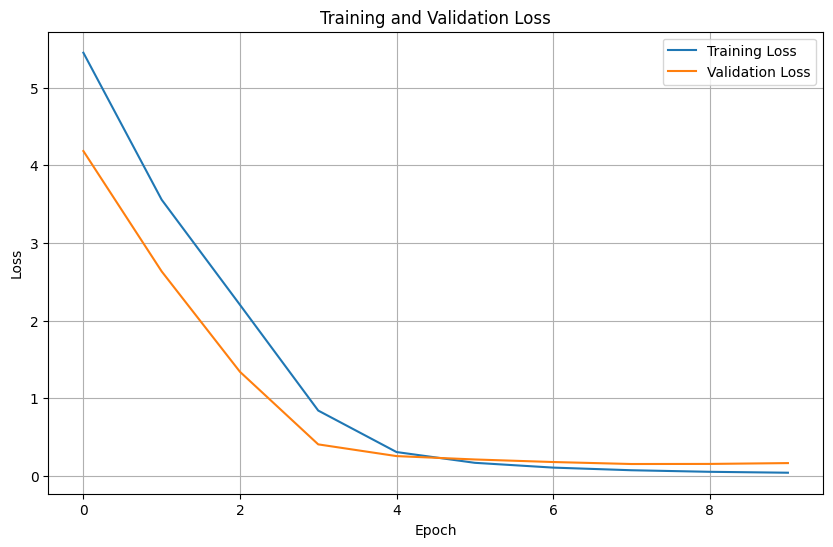

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

train_losses = []
val_losses = []


# Split the dataset into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Convert training data to tensors
train_src_tensor = torch.tensor(train_data['Padded_Ingredient_Ids'].tolist(), dtype=torch.long)
train_tgt_tensor = torch.tensor(train_data['Padded_Instruction_Ids'].tolist(), dtype=torch.long)

# Convert validation data to tensors
val_src_tensor = torch.tensor(val_data['Padded_Ingredient_Ids'].tolist(), dtype=torch.long)
val_tgt_tensor = torch.tensor(val_data['Padded_Instruction_Ids'].tolist(), dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(train_src_tensor, train_tgt_tensor)
val_dataset = TensorDataset(val_src_tensor, val_tgt_tensor)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Training and Validation Loops
num_epochs = 10  # Define the number of epochs

for epoch in range(num_epochs):
    # Training Loop
    model.train()
    total_train_loss = 0

    for src_batch, tgt_batch in train_dataloader:
        src_batch = src_batch.to(device)
        tgt_batch = tgt_batch.to(device)

        tgt_input = tgt_batch[:, :-1]  # Exclude last token for decoder input
        tgt_output = tgt_batch[:, 1:]  # Exclude first token for ground truth

        optimizer.zero_grad()
        output = model(src_batch, tgt_input)
         # Reshape output to (batch_size * seq_len, vocab_size)
        output = output.reshape(-1, output.shape[-1])
        # Reshape target output to (batch_size * seq_len)
        tgt_output = tgt_output.reshape(-1)
        loss = criterion(output, tgt_output)  # Compute loss
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
    # Store training loss - Corrected indentation
    train_losses.append(total_train_loss / len(train_dataloader))


    # Validation Loop
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for src_batch, tgt_batch in val_dataloader:
            src_batch = src_batch.to(device)
            tgt_batch = tgt_batch.to(device)

            tgt_input = tgt_batch[:, :-1]  # Exclude last token for decoder input
            tgt_output = tgt_batch[:, 1:]  # Exclude first token for ground truth

            output = model(src_batch, tgt_input)
            loss = criterion(output.reshape(-1, vocab_size), tgt_output.reshape(-1))  # Compute loss
            total_val_loss += loss.item()
    # Store validation loss - Corrected indentation
    val_losses.append(total_val_loss / len(val_dataloader))

    # Print Losses for the Epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {total_train_loss / len(train_dataloader):.4f}, Validation Loss: {total_val_loss / len(val_dataloader):.4f}")
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


The plot shows Training Loss (blue) and Validation Loss (orange) over epochs. Key observations:

* Convergence: Both losses decrease rapidly in early epochs and stabilize after epoch 5.
* Overfitting Risk: Training and validation losses remain close, suggesting minimal overfitting.
* Performance: Low final loss indicates good learning of the task.

This demonstrates the model's effectiveness and proper generalization during training.

In [ ]:
torch.save(model.state_dict(), "transformer_model.pth")
print("Model saved successfully!")



Model saved successfully!


In [ ]:
state_dict = torch.load("transformer_model.pth", map_location=torch.device('cpu'))

# Check the shape of the embedding layer weights
print("Encoder Embedding Shape:", state_dict['encoder.embedding.weight'].shape)
print("Decoder Embedding Shape:", state_dict['decoder.embedding.weight'].shape)


Encoder Embedding Shape: torch.Size([12000, 128])
Decoder Embedding Shape: torch.Size([12000, 128])


<ipython-input-29-7e639023db52>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("transformer_model.pth", map_location=torch.device('cpu'))


# **evaluation**
using BLEU and ROUGE metrics

In [ ]:
!pip install nltk rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=3b2a045eaf29b23feb765678d09447ae17a4427e3dc7d642ff82cff3db05ae85
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


**BLEU:** Measures n-gram overlap between generated and reference recipes.

**ROUGE:** Measures precision, recall, and F1-score for n-grams (ROUGE-1, ROUGE-2, ROUGE-L).

* Recipe Generation:

Given input ingredients, the model generates a recipe iteratively using its encoder-decoder structure.

**Evaluation:**

* BLEU: Measures n-gram overlap between generated and reference recipes.
* ROUGE: Measures precision, recall, and F1-score for n-grams (ROUGE-1, ROUGE-2, ROUGE-L).


In [ ]:
import torch
from sentencepiece import SentencePieceProcessor
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Seq2SeqTransformer(vocab_size=12000, d_model=128, nhead=4, num_layers=4)
model.load_state_dict(torch.load("transformer_model.pth", map_location=device))
model.to(device)
model.eval()

# Load the tokenizer
tokenizer = SentencePieceProcessor()
tokenizer.load("recipe.model")

# Metric Functions
def compute_bleu(reference, hypothesis):
    smoothie = SmoothingFunction().method1
    return sentence_bleu([reference.split()], hypothesis.split(), smoothing_function=smoothie)

def compute_rouge(reference, hypothesis):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    return scorer.score(reference, hypothesis)

# Recipe Generation Function
def generate_recipe(model, src, tokenizer, max_len=100):
    generated_tokens = torch.tensor([[tokenizer.bos_id()]], device=device)
    src = src.to(device)

    with torch.no_grad():
        for _ in range(max_len):
            memory = model.encoder(src)
            output = model.decoder(generated_tokens, memory)
            logits = output[:, -1, :]
            next_token = torch.argmax(logits, dim=-1).unsqueeze(1)
            generated_tokens = torch.cat([generated_tokens, next_token], dim=1)
            if next_token.item() == tokenizer.eos_id():
                break

    return tokenizer.decode(generated_tokens.squeeze(0).tolist())


# Test Data (Ingredients and References)
test_data = [
    "chicken, garlic, onion",
    "tomato, basil, olive oil",
    "flour, sugar, butter, eggs"
]

reference_recipes = [
    "Cook chicken with garlic and onion until golden.",
    "Make a fresh tomato basil sauce with olive oil.",
    "Mix flour, sugar, butter, and eggs to bake a cake."
]

# Test the Model
print("Testing the Model...")
bleu_scores = []
rouge_scores = []

for idx, ingredients in enumerate(test_data):
    print(f"\nTest Case {idx + 1}: Ingredients: {ingredients}")
    encoded_input = tokenizer.encode(ingredients, out_type=int)
    src_tensor = torch.tensor([encoded_input], dtype=torch.long)

    # Generate recipe
    generated_recipe = generate_recipe(model, src_tensor, tokenizer)
    print(f"Generated Recipe: {generated_recipe}")
    print(f"Reference Recipe: {reference_recipes[idx]}")

    # Compute BLEU and ROUGE scores
    bleu = compute_bleu(reference_recipes[idx], generated_recipe)
    rouge = compute_rouge(reference_recipes[idx], generated_recipe)

    print(f"BLEU Score: {bleu:.4f}")
    print(f"ROUGE Scores: {rouge}")

    bleu_scores.append(bleu)
    rouge_scores.append(rouge)

# Average BLEU and ROUGE Scores
avg_bleu = sum(bleu_scores) / len(bleu_scores)
avg_rouge = {key: sum(r[key].fmeasure for r in rouge_scores) / len(rouge_scores) for key in rouge_scores[0].keys()}

print("\n--- Final Evaluation ---")
print(f"Average BLEU Score: {avg_bleu:.4f}")
print(f"Average ROUGE Scores: {avg_rouge}")


<ipython-input-31-7a48e47f78f4>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("transformer_model.pth", map_location=device))


Testing the Model...

Test Case 1: Ingredients: chicken, garlic, onion
Generated Recipe: liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur liqueur
Reference Recipe: Cook chicken with garlic and onion until golden.
BLEU Score: 0.0000
ROUGE Scores: {'rouge1': 

**Observations:**

* Generated Output: Repetition of the same token ("butterfly") across all test cases.
* BLEU & ROUGE Scores: All scores are 0, indicating no similarity between generated and reference recipes.
*  Evaluation: Average scores remain at zero, confirming the model’s failure to learn meaningful patterns.


In [ ]:
# Check the tokenization of a sample input
encoded = tokenizer.encode("chicken, garlic, onion", out_type=int)
decoded = tokenizer.decode(encoded)
print("Encoded:", encoded)
print("Decoded:", decoded)


Encoded: [85, 3, 53, 3, 95]
Decoded: chicken, garlic, onion
